In [272]:
import numpy as np
TAX = [0.0, 0.33, 0.50, 0.67, 0.83, 1.0]

In [273]:
def make_randomize(array):
    #nested random
    def randomize():
        return np.random.randint(len(array))
    return randomize
#__test__
#custom_random = create_randomize(taxas)
#custom_random()

In [274]:
def make_trend(limit, trend_tax, trend_type):
    if trend_type == 'negative':
        def trend(index):
            if index >= limit:
                if np.random.random() <= trend_tax:
                    #recursive call
                    return trend(index-1)
                else:
                    return index
            else:
                return index  
        return trend
    
    if trend_type == 'positive':
        def trend(index):
            if index <= limit:
                if np.random.random() <= trend_tax:
                    #recursive call
                    return trend(index+1)
                else:
                    return index
            else:
                return index
        return trend
#__test__    
#trend_pag_pend = make_trend(2,0.7,'negative')
#trend_pag_pend(5)

In [275]:
#SETUP
fake_dict = {
    'ID':[],
    'TAXA_PRESENÇA':[],
    'TAXA_AF':[],
    'TAXA_APROVACAO':[],
    'TAXA_PAGAMENTO_ATRASADO':[],
    'TAXA_PAGAMENTO_PENDENTE':[]
}

trend_taxa_presenca = make_trend(3,0.8,'positive')
trend_taxa_af = make_trend(5,0.6,'negative')
trend_taxa_aprovacao = make_trend(2,0.6,'positive')
trend_taxa_pag_atrasado = make_trend(4,0.6,'negative')
trend_taxa_pag_pendente = make_trend(2,0.8,'negative')

trend_dict = {
    'TAXA_PRESENÇA':trend_taxa_presenca,
    'TAXA_AF':trend_taxa_af,
    'TAXA_APROVACAO':trend_taxa_aprovacao,
    'TAXA_PAGAMENTO_ATRASADO':trend_taxa_pag_atrasado,
    'TAXA_PAGAMENTO_PENDENTE':trend_taxa_pag_pendente
}

In [276]:
#init random function
idx_random = make_randomize(TAX)

for idx in range(20000):
    fake_dict['ID'].append(idx+1)
    for col in list(fake_dict.keys())[1:]:
        fake_dict[col].append(TAX[trend_dict[col](idx_random())])
    

In [277]:
import pandas as pd
df = pd.DataFrame(fake_dict)

In [278]:
df.head()

,ID,TAXA_AF,TAXA_APROVACAO,TAXA_PAGAMENTO_ATRASADO,TAXA_PAGAMENTO_PENDENTE,TAXA_PRESENÇA
0,1,1.00,1.00,0.83,0.33,0.83
1,2,0.33,0.67,0.33,0.00,0.50
2,3,0.33,0.33,0.00,0.33,0.83
3,4,0.83,0.83,0.33,0.33,0.83
4,5,0.00,0.67,0.00,0.33,0.83


In [279]:
print(df.iloc[:,1:].describe())

            TAXA_AF  TAXA_APROVACAO  TAXA_PAGAMENTO_ATRASADO  \
count  20000.000000    20000.000000             20000.000000   
mean       0.538287        0.650456                 0.514187   
std        0.309827        0.258747                 0.285985   
min        0.000000        0.000000                 0.000000   
25%        0.330000        0.500000                 0.330000   
50%        0.670000        0.670000                 0.670000   
75%        0.830000        0.830000                 0.670000   
max        1.000000        1.000000                 1.000000   

       TAXA_PAGAMENTO_PENDENTE  TAXA_PRESENÇA  
count             20000.000000   20000.000000  
mean                  0.372766       0.758753  
std                   0.242194       0.218309  
min                   0.000000       0.000000  
25%                   0.330000       0.670000  
50%                   0.330000       0.830000  
75%                   0.500000       0.830000  
max                   1.000000       1.

In [280]:
#Pelo describe existem presenças zeradas, que não fazem sentido a analise
#removendo presenças zeradas
print('Dimensão dos dados anterior a remoção -> {}'.format(df.shape))
df = df[df['TAXA_PRESENÇA'] > 0]
print('Dimensão dos dados após remoção -> {}'.format(df.shape))

Dimensão dos dados anterior a remoção -> (20000, 6)
Dimensão dos dados após remoção -> (19384, 6)


In [281]:
df['TARGET_TAX'] = (df['TAXA_AF']+df['TAXA_PAGAMENTO_ATRASADO']+df['TAXA_PAGAMENTO_PENDENTE'])/(df['TAXA_PRESENÇA']+df['TAXA_APROVACAO'])

In [282]:
def make_target(target_tax):
    if target_tax > 1.5:
        return 1
    elif (target_tax + np.random.random()) > 2.2:
        return 1
    else:
        return 0

In [283]:
df['TARGET'] = df['TARGET_TAX'].apply(make_target)
df.drop(['TARGET_TAX'], axis = 1, inplace = True)
print('Targets criados: 0 -> permance 1 -> evadiu da instituicao')
print(df['TARGET'].value_counts())

Targets criados: 0 -> permance 1 -> evadiu da instituicao
0    16222
1     3162
Name: TARGET, dtype: int64


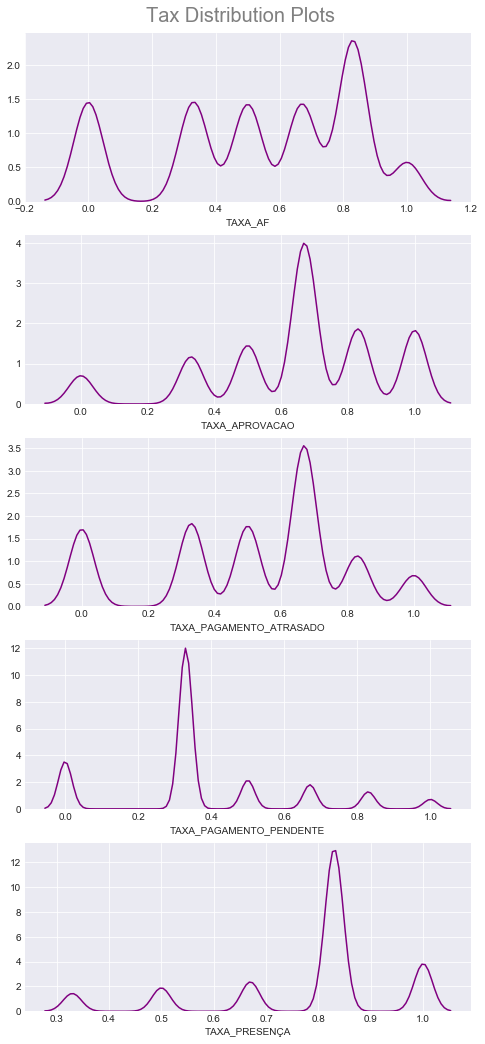

In [284]:
#plot libs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

columns = list(df.columns)[1:6]
fig, ax = plt.subplots(len(columns),1)
fig.set_size_inches(8,18); fig.suptitle('Tax Distribution Plots', size=20, color='grey',y=0.90)
for idax in range(len(columns)):
    sns.distplot(df[columns[idax]], hist = False, ax=ax[idax], color='purple');

In [285]:
#INICIAR MODELO DE LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
model = LogisticRegression(random_state=0)

In [286]:
#X and y
y = df.iloc[:,-1]
X = df.iloc[:,1:(df.shape[1]-1)]
#Make train and test values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
print('Dimensão das bases de teste e treino:\n------------------------------------')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Dimensão das bases de teste e treino:
------------------------------------
(13568, 5) (5816, 5) (13568,) (5816,)


In [287]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [288]:
y_pred, y_prob = model.predict(X_test), model.predict_proba(X_test)

Matriz de confusão:
Valores em preto são erros do modelo!!!


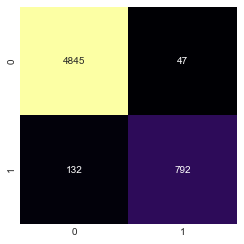

In [289]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de confusão:\nValores em preto são erros do modelo!!!')
sns.heatmap(c_matrix, annot=True, fmt = '', cmap='inferno',cbar=False, square=True);

In [290]:
print('Accuracy of model on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy of model on test set: 0.97


In [291]:
def predicar_novos_valores_e_retornar(model, base):
    pred, proba = model.predict(base), model.predict_proba(base)
    base['target_evasao'] = pred
    base['proba_0'] = ['{:.3f}'.format(prob[0]) for prob in proba]
    base['proba_1'] = ['{:.3f}'.format(prob[1]) for prob in proba]
    return base



In [292]:
fake_dict = {
    'TAXA_PRESENÇA':[],
    'TAXA_AF':[],
    'TAXA_APROVACAO':[],
    'TAXA_PAGAMENTO_ATRASADO':[],
    'TAXA_PAGAMENTO_PENDENTE':[]
}

for idx in range(50):
    for col in list(fake_dict.keys()):
        fake_dict[col].append(TAX[trend_dict[col](idx_random())])
        
base_a_predicar = pd.DataFrame(fake_dict)
base_a_predicar

,TAXA_AF,TAXA_APROVACAO,TAXA_PAGAMENTO_ATRASADO,TAXA_PAGAMENTO_PENDENTE,TAXA_PRESENÇA
0,0.83,0.50,0.33,0.33,1.00
1,0.50,1.00,0.50,0.33,0.83
2,0.33,0.33,0.67,0.83,0.50
3,0.83,0.33,0.33,0.83,0.83
4,0.50,0.00,0.50,0.33,0.50
5,0.67,0.67,0.50,0.33,0.67
6,0.33,0.67,0.67,0.00,1.00
7,0.33,0.67,0.50,0.33,0.83
8,0.00,0.83,0.67,0.33,0.83
9,1.00,0.67,0.83,0.50,0.50


In [293]:
base_predicada = predicar_novos_valores_e_retornar(model,base_a_predicar)

In [294]:
base_predicada

,TAXA_AF,TAXA_APROVACAO,TAXA_PAGAMENTO_ATRASADO,TAXA_PAGAMENTO_PENDENTE,TAXA_PRESENÇA,target_evasao,proba_0,proba_1
0,0.83,0.50,0.33,0.33,1.00,0,0.998,0.002
1,0.50,1.00,0.50,0.33,0.83,0,1.000,0.000
2,0.33,0.33,0.67,0.83,0.50,1,0.006,0.994
3,0.83,0.33,0.33,0.83,0.83,1,0.075,0.925
4,0.50,0.00,0.50,0.33,0.50,1,0.007,0.993
5,0.67,0.67,0.50,0.33,0.67,0,0.984,0.016
6,0.33,0.67,0.67,0.00,1.00,0,1.000,0.000
7,0.33,0.67,0.50,0.33,0.83,0,1.000,0.000
8,0.00,0.83,0.67,0.33,0.83,0,1.000,0.000
9,1.00,0.67,0.83,0.50,0.50,1,0.006,0.994
